# Sentiment Analysis Coursework
Alex Dawkins (asd60@bath.ac.uk), python 3.8

The aim of this coursework is to write a sentiment analysis application to classify
movie reviews as either **positive**, or **negative**.

## The Dataset

The dataset is 25,000 highly polar movie reviews. It has already been split into training and testing subsets.
The dataset can be found [here](https://ai.stanford.edu/~amaas/data/sentiment/).


In [6]:
from typing import List

# Import and setup NLTK
import nltk
import os
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexdawkins/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Load the reviews
import os
train_dir = 'data/aclImdb/train'
neg_train_dir = f'{train_dir}/neg'
pos_train_dir = f'{train_dir}/pos'

def load_reviews(fps, dir_: str):
    reviews = []
    for fp in fps:
        with open(dir_ + '/' + fp, 'r') as f:
            reviews.append(f.read())

    return reviews

neg_fps = [fp for fp in os.listdir(neg_train_dir) if fp.endswith('.txt')]
pos_fps = [fp for fp in os.listdir(pos_train_dir) if fp.endswith('.txt')]


pos_reviews = load_reviews(pos_fps, pos_train_dir)
neg_reviews = load_reviews(neg_fps, neg_train_dir)

print(f"Loaded {len(pos_reviews)} positive reviews, and {len(neg_reviews)} negative reviews.\n---")
print(f"{pos_reviews[0]=}")
print(f"{neg_reviews[0]=}")

Loaded 12500 positive reviews, and 12500 negative reviews.
---
pos_reviews[0]='For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.'
neg_reviews[0]="Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form."


Although the reviews in the dataset are written by many different people, it's possible that there could be some
deviations in the lengths of reviewers' words or sentences, depending on whether they are talking about something
in a positive or a negative manner.

Perhaps more critical reviews are more likely to use longer, more technical words as the reviewers wants to use technical
language to reason their point.

Alternatively, there might be no correlation at all, as any consistency between up to 12,500 reviews is quite unlikely.
This approach is more likely to be effective to distinguish between two different authors.

In [8]:
def lengths(data: str, name: str):
    words = nltk.tokenize.word_tokenize(data)
    num_words = len(words)
    avg_word_len = round(len(data) / num_words)
    avg_sent_len = round(num_words / len(nltk.tokenize.sent_tokenize(data)))
    # average number of times each word occurs uniquely
    avg_n_unique_word = round(num_words / len(set(w.lower() for w in words)))
    print(avg_word_len, avg_sent_len, avg_n_unique_word, name)

# Limit number of reviews. my computer can't handle any more.
n_reviews = 1000

# Turn the lists into strings
all_pos_reviews = '\n'.join(pos_reviews[:n_reviews])
all_neg_reviews = '\n'.join(neg_reviews[:n_reviews])

lengths(all_pos_reviews, 'pos')
lengths(all_neg_reviews, 'neg')

5 28 14 pos
5 26 14 neg


There doesn't appear to be any difference at all! **This technique will not work for categorising the data,** as both
positive and negative reviews have very similar word and sentence length, and amount of unique vocabulary.


As part of the data set, a tokenised list of words (`imdb.vocab`), and the associated expected rating for each token
(`imdbEr.txt`). This list of expected ratings was computed by (Potts, 2011).

We can take the sum of each word's expected rating as the review's expected rating.

In [27]:
def try_make_float(x):
    try:
        return float(x)
    except ValueError:
        return 0.

with open("data/aclImdb/imdb.vocab", 'r') as f:
        vocab = f.read().split('\n')

# faster than vocab.index()
vocab_index = {word: i for i, word in enumerate(vocab)}

with open("data/aclImdb/imdbEr.txt", 'r') as f:
    expected_ratings = list(map(try_make_float, f.read().split('\n')))

In [47]:
def evaluate(modifier=None):
    if not modifier:
        def modifier(_):
            return 1
    n_positive = 0
    for i, rev in enumerate(pos_reviews):
        words = [word.lower() for word in nltk.word_tokenize(rev) if word not in '.,\'"']
        expected_rating = 0
        n_words = len(words)
        for j, word in enumerate(words):
            idx = vocab_index.get(word, None)
            if not idx:
                continue
            expected_rating += modifier(j/n_words) * expected_ratings[idx]

        if expected_rating > 0:
            # print(n_positive, i)
            n_positive += 1

    print(f"Accuracy: {n_positive}/{len(pos_reviews)} ({n_positive/len(pos_reviews)})")

In [30]:
evaluate()

Accuracy: 10839/12500 (0.86712)


From reading some of the reviews, I found that a lot of them include a lot of pre-amble, describing the context of how
the reviewer watched the movie, their initial thoughts, etc. These words are independent of the sentiment of the whole
review.

For example, `pos/13_9.txt`:

 >I work at a movie theater and every Thursday night we have an employee screening of one movie that comes out the next day...Today it was The Guardian. I saw the trailers and the ads and never expected much from it, and in no way really did i anticipate seeing this...


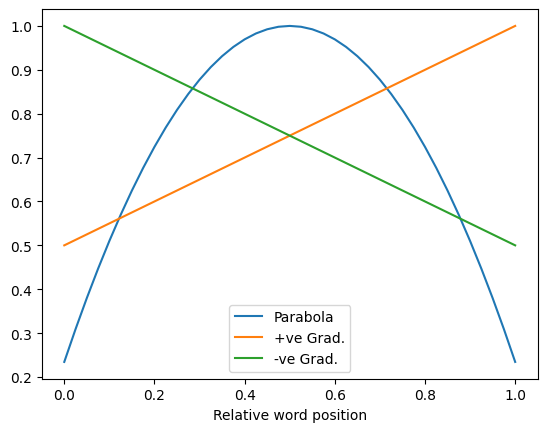

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def parabola(x_):
    return (-(1.75 * x_ - 0.875) ** 2) + 1
def positive_gradient(x_):
    return ( 0.5 * x_ ) + 0.5
def negative_gradient(x_):
    return -( 0.5 * x_ ) + 1


x = np.linspace(0, 1, 41)
plt.plot(x, parabola(x),label="Parabola")
plt.plot(x, positive_gradient(x),label="+ve Grad.")
plt.plot(x, negative_gradient(x),label="-ve Grad.")
plt.xlabel('Relative word position')
plt.legend()
plt.show()

In [29]:
evaluate(modifier=parabola)

Accuracy: 10835/12500 (0.8668)


In [50]:
evaluate(modifier=positive_gradient)

Accuracy: 10858/12500 (0.86864)


Some reviews get straight to the point, such as `pos/17_8.txt`:
 > Brilliant and moving performances by Tom Courtenay and Peter Finch.

In [51]:
evaluate(modifier=negative_gradient)

Accuracy: 10818/12500 (0.86544)


Adding weights for the positions of words within the reviews doesn't appear to significantly improve performance, and I
haven't experimented enough to warrant keeping this technique within the solution.

As using Potts' list appears to be very effective, I wanted to try to recreate the list, using the training data.

This code iterates through each word in every review and assigns the word a portion of the rating: if a review is 10
stars, and it contains 2 words, these 2 words are clearly (and assumed equally) positive words, and should be considered
more significant than a word that appears once in a long review.

In [ ]:
import json
import re

regex = re.compile('[^a-zA-Z]')

def clean(x):
    return regex.sub(' ', x).lower()

def make_er(train_data, ratings, use_cache=False):
    if use_cache:
        with open('results.txt', 'r') as f:
            return json.load(f)

    vocab_ratings = {}
    vocab_occurrences = {}
    porter = nltk.PorterStemmer()
    n_reviews = len(train_data)
    for i, rev in enumerate(train_data):
        words = nltk.word_tokenize(clean(rev))
        stems = [porter.stem(word) for word in words]
        n_words = len(words)
        # Convert (1 to 10) to (-5 to 4)
        rating = ratings[i] - 6
        rel_rating = rating / n_words
        for word in stems:
            vocab_ratings[word] = vocab_ratings.get(word, 0) + rel_rating
            vocab_occurrences[word] = vocab_occurrences.get(word, 0) + 1
        if i % 1000 == 0:
            print(f"{i}/{n_reviews}...")
    vocab_ratings = {word: sum_ / vocab_occurrences[word] for word, sum_ in vocab_ratings.items()}
    with open('results.txt', 'w') as f:
        f.write(json.dumps(vocab_ratings))

    return vocab_ratings